# FYP-Audio Preprocessing
Supervisor: Peter Jancovic
Student: Yuxuan Yang 1976844

## Reliable Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

Selected Examples

In [2]:
list_of_source = "D:\projectRESEARCH\CNN\Aut_Week2\codex\sourcelist.txt"
with open(list_of_source) as f:
    filename = f.readlines()
filename

['D:\\projectRESEARCH\\CNN\\Aut_Week2\\codex\\Study5.wav\n',
 'D:\\projectRESEARCH\\CNN\\Aut_Week2\\codex\\Study6.wav\n',
 'D:\\projectRESEARCH\\CNN\\Aut_Week2\\codex\\Study11.wav\n',
 'D:\\projectRESEARCH\\CNN\\Aut_Week2\\codex\\Study17.wav']

## Original Signal in Time Domain

In [3]:
sample_rate, data = wavfile.read('D:\projectRESEARCH\CNN\Aut_Week2\codex\Study5.wav')
signal_length = len(data)
frame_length = 1024
frame_step = 512
number_of_frame = int(np.ceil((signal_length - frame_length) / frame_step))

 ## Split data samples to Frames
    Let the last frame complete, extended samples all zero

In [4]:
    extended_signal_length = number_of_frame * frame_step + frame_length
    extended_zeros = np.zeros(extended_signal_length - signal_length)
    extended_data = np.append(data, extended_zeros)
    index_of_frames = np.tile(np.arange(0, frame_length), (number_of_frame, 1)) \
                      + np.tile(np.arange(0, number_of_frame * frame_step, frame_step), (frame_length, 1)).T
    dataFrame = extended_data[index_of_frames.astype(np.int32, copy=False)]

 ## Windowing the frame

In [5]:
    dataFrameWindowed = np.hamming(frame_length) * dataFrame

## N point FFT and spectrogram
    NFFT = T*Fs, T is duration of frame, F is sampling frequency

In [6]:
    NFFT = (frame_length / sample_rate) * sample_rate
    frame_magnitude = np.absolute(np.fft.rfft(dataFrameWindowed, NFFT))
    power_spectrum = (1 / NFFT) * (frame_magnitude ** 2)

Text(0, 0.5, 'frequency bin')

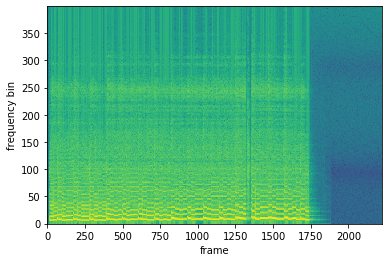

In [7]:

plt.imshow(np.log(power_spectrum).T[:400], origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')

 ## Filter Banks and logFBE
    For 44100 frequency range divided into 40 filters
    Reference to paper "Practical Cryptography"

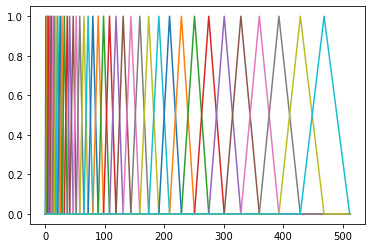

In [8]:
    number_of_filter = 40
    # Find range of mel from 0 to sample_rate
    low_freq_mel = 0
    high_freq_mel = 2595 * (np.log10(1 + (sample_rate / 2) / 700))  # convert hz to mel
    # divided this interval into equally space point
    mel_points = np.linspace(low_freq_mel, high_freq_mel,number_of_filter + 2)
    # We need to find FFT frequency point, so converted back to frequency point
    hz_points = 700 * (10 ** (mel_points / 2595) - 1)  # convert mel to hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)  # Round those frequency to nearest FFT bin.

    fbank = np.zeros((number_of_filter, int(np.floor(NFFT / 2 + 1))))  # Initialize triangular filter list
    # The filterbank will start at the first point, reach peak at second point, return zero at 3rd point
    for m in range(1, number_of_filter + 1):
        f_m_minus = int(bin[m - 1])         # left:   the first point
        f_m = int(bin[m])                   # center: the second point
        f_m_plus = int(bin[m + 1])          # right:  the third point
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    #  Apply filter to power spectrum
    #  plt.plot(fbank.T)
    filter_banks = np.dot(power_spectrum, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    logfilter_banks = 20 * np.log10(filter_banks)  # logFBE in dB
    plt.plot(fbank.T)

## MFCC

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, 'frequency bin')

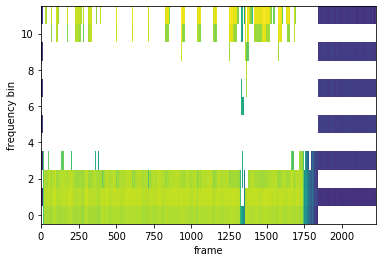

In [9]:
    num_ceps = 12
    cep_lifter=22
    mfcc = dct(filter_banks,type=2,axis=1, norm= 'ortho')[:,1:(num_ceps+1)]
    (nframes, ncoeff)= mfcc.shape
    n = np.arange(ncoeff)
    lift = 1+(cep_lifter/2)*np.sin(np.pi*n/cep_lifter)
    mfcc*=lift
plt.imshow(np.log(mfcc).T[:400], origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')